## Imports

In [1]:
%autoreload
from collections import defaultdict
import itertools
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceGraph_ELBO, config_enumerate
from pyro import poutine
from pyro.optim import Adam
import gpytorch as gp
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel, ProductKernel, LinearKernel, AdditiveKernel
import visdom
import pdb
from pmextract import extract
import matplotlib.pyplot as plt
import autostat as a
from pyrsistent import pset, s
import functools
from queue import Queue
import time

In [2]:
LOGRATE = 20

In [3]:
vis = visdom.Visdom(env='nb')

Setting up a new session...


## Fake Data

In [27]:
p = a.Prog(s(), s(s(a.Action.Linear), s(a.Action.Periodic, a.Action.RBF)), True)

In [28]:
p

Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>, <Action.RBF: 4>]), pset([<Action.Linear: 5>])]), done=True)

In [29]:
k = a.to_kernel(p)

In [30]:
x = (torch.arange(100) / 30)

In [31]:
x1 = x[:50, None]

In [32]:
x2 = x[50:, None]

In [33]:
fancy_y = a.gp_model(None, k, x1, None).detach()

In [34]:
with torch.no_grad():
    fancy_y2 = k(x2, x1) @ k(x1).add_diag(torch.tensor(0.001)).inv_matmul(fancy_y)

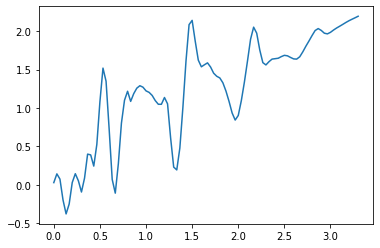

In [35]:
plt.plot(x, torch.cat((fancy_y, fancy_y2)))

## Greedy Training

In [36]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})

In [37]:
best_logprob = -torch.inf
best_prog = None
level_trace = poutine.Trace()
epoch = 0
for d in range(1, 5):
    def wrapped():
        try:
            with a.RejectionMessenger(functools.partial(a.deep_escape, d)):
                return a.path_guide(KERNS)
        except a.RejectException as site:
            site.reset_stack()
            return None
    q = Queue()
    q.put(level_trace)
    queued = poutine.queue(wrapped, queue=q)
    traces = {}
    probs = defaultdict(lambda: torch.tensor(0.0))
    likelihoods = {}
    while not q.empty():
        with poutine.trace() as capture:
            res = queued()
        if res is not None:
            prog, logp, kern, newkern = res
            probs[prog] += torch.exp(logp.detach())
            if newkern:
                loss = torch.tensor(0.0)
                for _ in range(100):
                    tr = poutine.trace(a.gp_model).get_trace(
                        prog, kern, x1, fancy_y)
                    loss = -tr.log_prob_sum() - a.prior_logprob(kern)
                    params = [n['value'].unconstrained()
                        for n in tr.nodes.values() if n['type'] == 'param']
                    loss.backward()
                    opt(params)
                    pyro.infer.util.zero_grads(params)
                trace = capture.trace
                final_sample = [v['name'] for v in trace.nodes.values()
                    if type(v['name']) is a.Prog][-1]
                trace.remove_node(final_sample)
                traces[prog] = trace
                likelihoods[prog] = -loss.detach()
    level_prog = None
    level_logprob = -torch.inf
    for key,v in likelihoods.items():
        logp = v + probs[key]
        if logp >= level_logprob:
            level_logprob = logp
            level_prog = key
    level_trace = traces[level_prog]
    print("Best on previous level", level_prog)
    if level_logprob > best_logprob:
        best_logprob = level_logprob
        best_prog = level_prog
    else:
        break

Best on previous level Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>, <Action.RBF: 4>])]), done=True)
Best on previous level Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>, <Action.RBF: 4>]), pset([<Action.Linear: 5>])]), done=True)


In [38]:
p

Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>, <Action.RBF: 4>]), pset([<Action.Linear: 5>])]), done=True)

In [40]:
poutine.trace(a.gp_model).get_trace(p, k, x1, fancy_y).log_prob_sum()

tensor(27.2337, grad_fn=<AddBackward0>)

In [41]:
poutine.trace(a.gp_model).get_trace(best_prog, KERNS[best_prog], x1, fancy_y).log_prob_sum()

tensor(26.8101, grad_fn=<AddBackward0>)

In [42]:
poutine.trace(a.gp_model).get_trace(best_prog, KERNS[best_prog], x2, fancy_y2).log_prob_sum()

tensor(40.0474, grad_fn=<AddBackward0>)

In [43]:
poutine.trace(a.gp_model).get_trace(p, k, x2, fancy_y2).log_prob_sum()

tensor(49.2310, grad_fn=<AddBackward0>)

## ELBO GFlow Training

In [159]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})
secs = int(time.time())

In [160]:
accum_loss = torch.tensor(0.0)
accum_kl= torch.tensor(0.0)
for epoch in range(1000 * LOGRATE):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, kern, x1, fancy_y)
        loss = -tr.log_prob_sum() - a.prior_logprob(kern)
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        pyro.infer.util.zero_grads(params)
    logq = capture.trace.log_prob_sum()
    if epoch % LOGRATE == 0:
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_kl[None] / LOGRATE,
            update='append', win=f"{secs} kl", opts={
                'title': "Elbo GFlow KL estimate"})
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_loss[None] / LOGRATE,
            update='append', win=f"{secs} loss", opts={
                'title': "Elbo GFlow Loss"})
        accum_loss.zero_()
        accum_kl.zero_()
        validation = torch.tensor(0.0)
        with torch.no_grad():
            for _ in range(10):
                tr2 = poutine.trace(a.gp_model).get_trace(prog, kern, x2, fancy_y2)
                validation += tr2.log_prob_sum()
            validation_logp = validation / 10
            vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=validation_logp[None],
                update='append', win=f"{secs} val", opts={
                    'title': "Elbo GFlow Validation Logp"})
    kl_sample = (logq - logp + (loss / len(x1))).detach()
    accum_kl += (logq - logp).detach()
    accum_loss += loss.detach() / len(x1)
    outer_loss = logq * kl_sample
    outer_loss.backward()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    opt(outer_params)
    pyro.infer.util.zero_grads(outer_params) 

/home/sam/.local/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sam/.local/lib/python3.10/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


KeyboardInterrupt: 

## Original GFlow Training

In [92]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})

In [93]:
accum_loss = torch.tensor(0.0)
logz = torch.tensor(0.0, requires_grad=True)
for epoch in range(300000):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, kern, x1, fancy_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        pyro.infer.util.zero_grads(params)
    logq = capture.trace.log_prob_sum()
    if epoch % LOGRATE == 0:
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_loss[None] / LOGRATE,
            update='append', win='loss2', opts={
                'title': "Loss2"})
        accum_loss.zero_()
        validation = torch.tensor(0.0)
        with torch.no_grad():
            for _ in range(10):
                tr2 = poutine.trace(a.gp_model).get_trace(prog, kern, x2, fancy_y2)
                validation += tr2.log_prob_sum()
            validation_logp = validation / 10
            vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=validation_logp[None],
                update='append', win='og_validation', opts={
                    'title': "OG GFlow Validation Logp"})
    outer_loss = torch.square(logq - logp + logz)
    accum_loss += outer_loss.detach()
    outer_loss.backward()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    outer_params.append(logz)
    opt(outer_params)
    pyro.infer.util.zero_grads(outer_params) 

KeyboardInterrupt: 

## REINFORCE Training

In [86]:
pyro.clear_param_store()
KERNS = {}
opt = Adam({"lr": 1e-3, "betas": (0.90, 0.999)})

In [87]:
accum_loss = torch.tensor(0.0)
for epoch in range(300000):
    with poutine.trace() as capture:
        prog, logp, kern, newkern = a.path_guide(KERNS)
    for _ in range(10 if newkern else 1):
        tr = poutine.trace(a.gp_model).get_trace(prog, kern, x1, fancy_y)
        loss = -tr.log_prob_sum()
        params = [n['value'].unconstrained()
              for n in tr.nodes.values() if n['type'] == 'param']
        loss.backward()
        opt(params)
        pyro.infer.util.zero_grads(params)
    logq = capture.trace.log_prob_sum()
    if epoch % LOGRATE == 0:
        vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=accum_loss[None] / LOGRATE,
            update='append', win='rf_loss', opts={
                'title': "REINFORCE Loss"})
        accum_loss.zero_()
        validation = torch.tensor(0.0)
        with torch.no_grad():
            for _ in range(10):
                tr2 = poutine.trace(a.gp_model).get_trace(prog, kern, x2, fancy_y2)
                validation += tr2.log_prob_sum()
            validation_logp = validation / 10
            vis.line(X=torch.tensor([epoch / LOGRATE]),
                 Y=validation_logp[None],
                update='append', win='rf_validation', opts={
                    'title': "REINFORCE GFlow Validation Logp"})
    outer_loss = loss.detach() * logq
    outer_loss.backward()
    accum_loss += loss.detach()
    outer_params = [n['value'].unconstrained()
        for n in capture.trace.nodes.values() if n['type'] == 'param']
    opt(outer_params)
    pyro.infer.util.zero_grads(outer_params) 

KeyboardInterrupt: 

## Multimodality

In [161]:
def full_model():
    prog, logp, kern, newkern = a.path_guide(KERNS)
    return prog

In [162]:
a.all_in_quantile(full_model, 0.5)

[Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>]), pset([<Action.Periodic: 3>, <Action.RBF: 4>])]), done=True),
 Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>, <Action.RBF: 4>]), pset([<Action.Linear: 5>])]), done=True)]

In [163]:
with a.MAPMessenger():
    result = full_model()
result 

Prog(builder=pset(), adds=pset([pset([<Action.Periodic: 3>, <Action.RBF: 4>]), pset([<Action.Linear: 5>])]), done=True)